In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
from textblob import Word
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.ticker as ticker

# set visual style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# download necessary nltk data
nltk.download('stopwords', quiet=True)
nltk.download('vader_lexicon', quiet=True)

# load dataset
df = pd.read_csv('amazon_reviews.csv')

# preprocessing function
def preprocess(text):
    text = str(text).lower()
    text = ''.join(ch if ch.isalpha() or ch.isspace() else ' ' for ch in text)
    tokens = [w for w in text.split() if w not in stopwords.words('english')]
    return ' '.join(Word(w).lemmatize() for w in tokens)

# apply preprocessing
df['clean_text'] = df['reviewText'].fillna('').apply(preprocess)

# feature engineering
sia = SentimentIntensityAnalyzer()
df['polarity'] = df['clean_text'].apply(lambda x: sia.polarity_scores(x)['compound'])
df['review_len'] = df['clean_text'].str.split().map(len)
df['helpful_yes'] = df.get('helpful_yes', 0)
df['total_vote'] = df.get('total_vote', 0)
df['helpful_ratio'] = df['helpful_yes'] / df['total_vote'].replace(0,1)
df['helpful_no'] = df.get('helpful_no', 0)
df['day_diff'] = df.get('day_diff', np.nan)
df['overall'] = df.get('overall', np.nan)
df['reviewTime'] = pd.to_datetime(df.get('reviewTime', ''), errors='coerce')
df['year'] = df['reviewTime'].dt.year

# print dataset info
print(f"dataset shape: {df.shape}")
print("columns:", df.columns.tolist())
print("\ndataset info:")
print(df.info())
print("\ndescriptive statistics:")
print(df.describe().round(2))

dataset shape: (4915, 17)
columns: ['Unnamed: 0', 'reviewerName', 'overall', 'reviewText', 'reviewTime', 'day_diff', 'helpful_yes', 'helpful_no', 'total_vote', 'score_pos_neg_diff', 'score_average_rating', 'wilson_lower_bound', 'clean_text', 'polarity', 'review_len', 'helpful_ratio', 'year']

dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4915 entries, 0 to 4914
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   Unnamed: 0            4915 non-null   int64         
 1   reviewerName          4914 non-null   object        
 2   overall               4915 non-null   float64       
 3   reviewText            4914 non-null   object        
 4   reviewTime            4915 non-null   datetime64[ns]
 5   day_diff              4915 non-null   int64         
 6   helpful_yes           4915 non-null   int64         
 7   helpful_no            4915 non-null   int64         
 8   

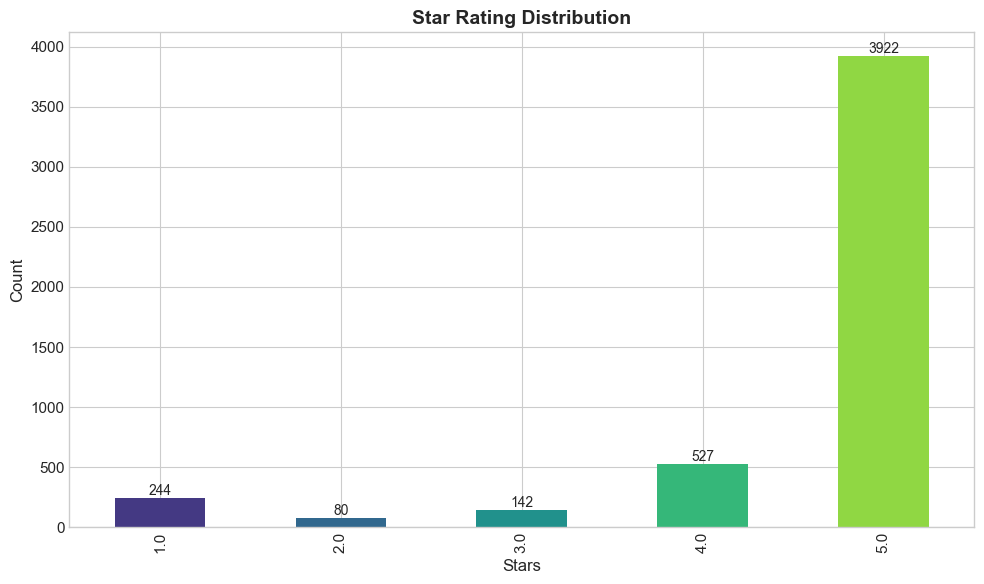

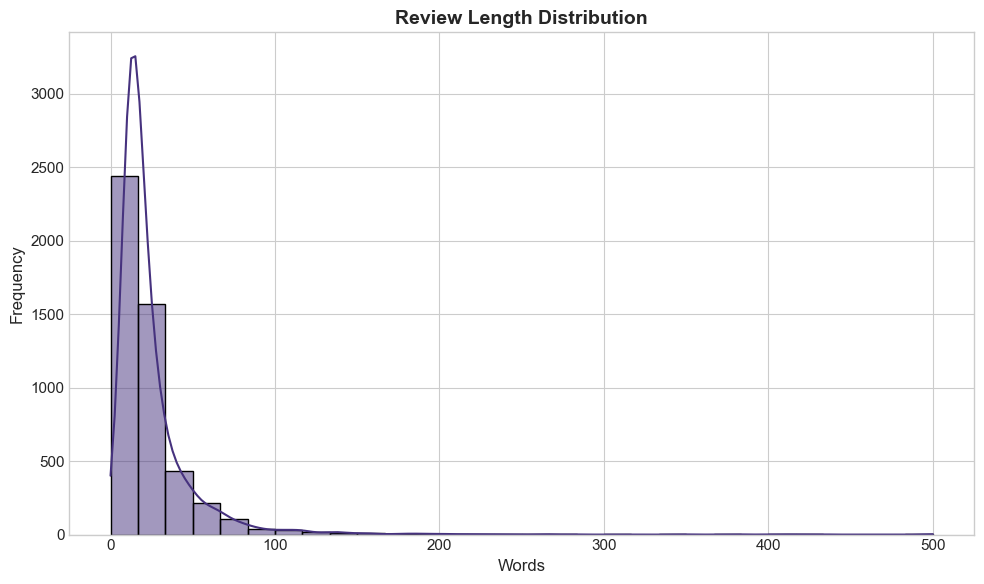

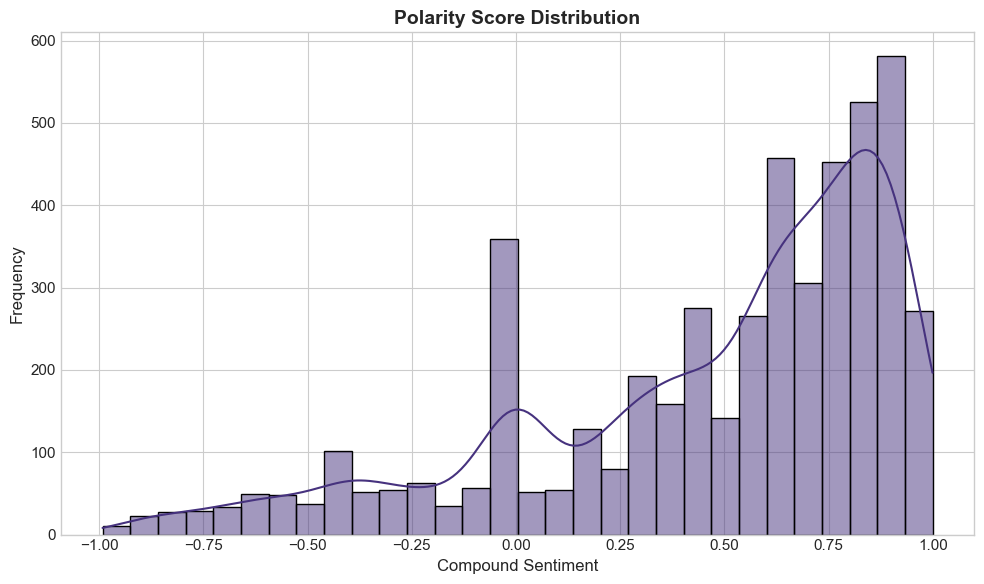

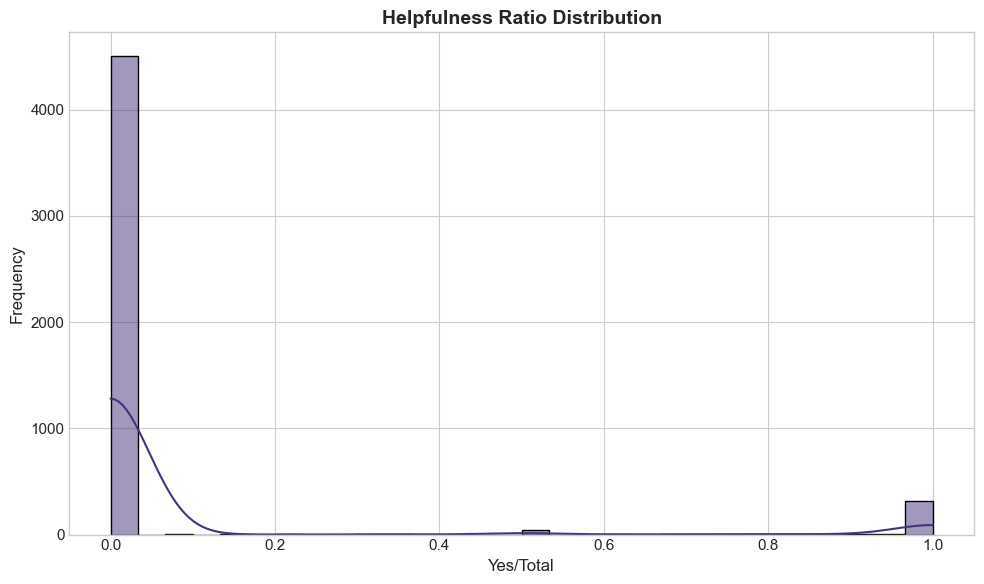

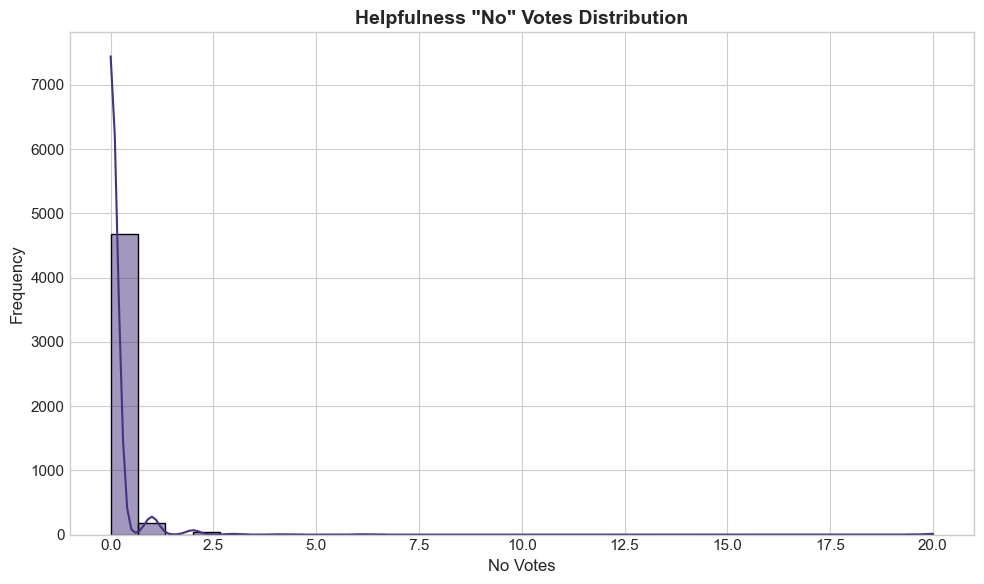

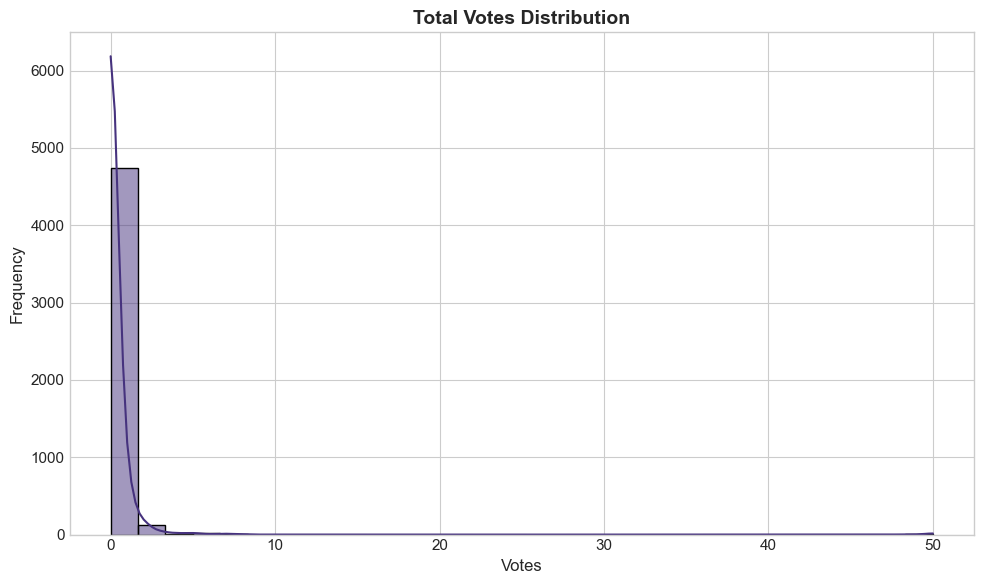

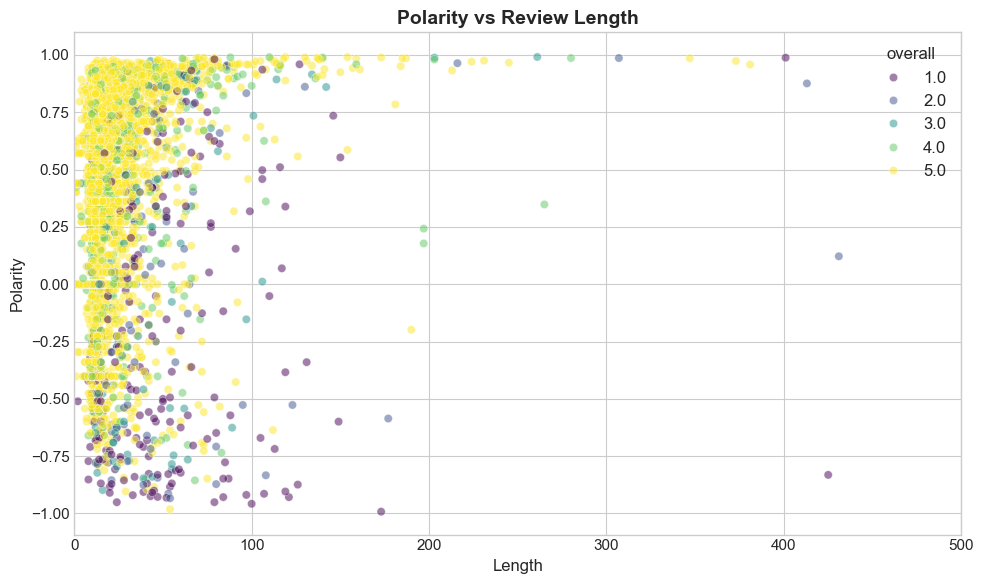

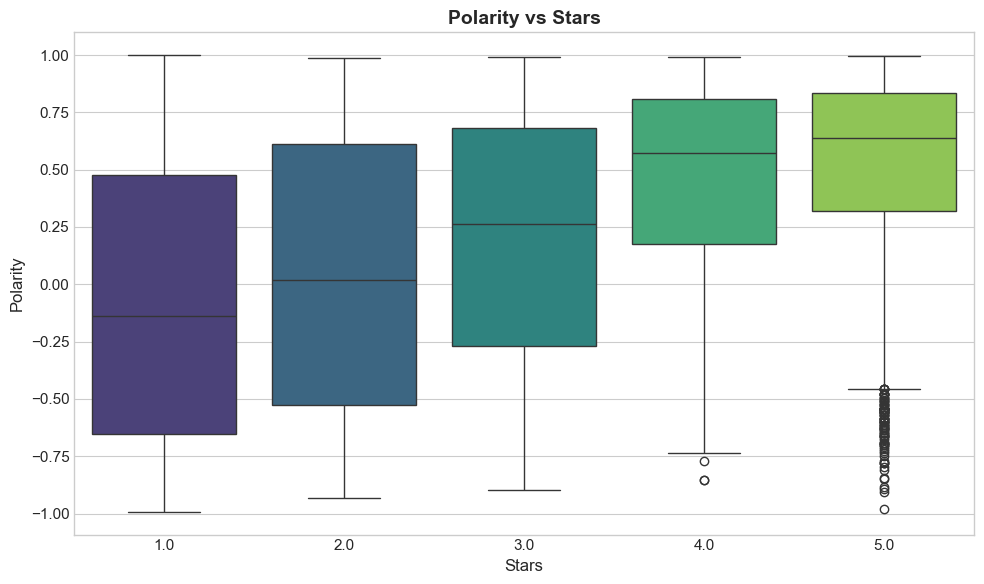

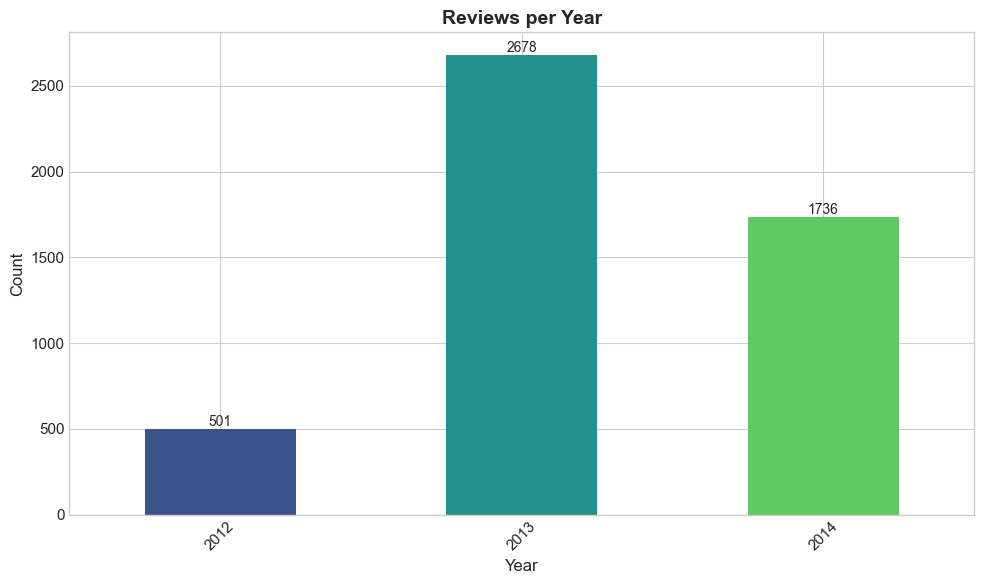

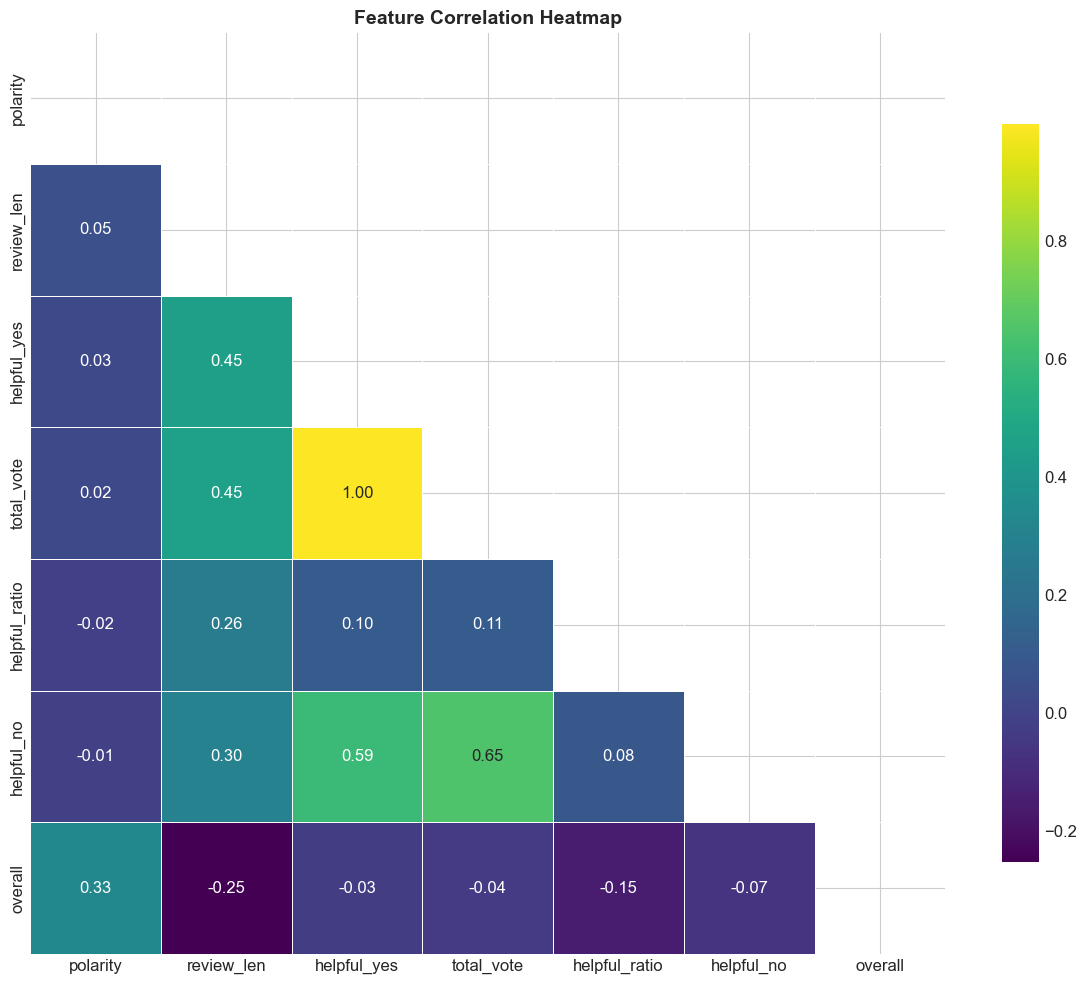

In [2]:
# eda plots - sequential formatting
plt.figure(figsize=(10, 6))
ax = df['overall'].dropna().value_counts().sort_index().plot.bar(color=sns.color_palette('viridis', 5))
plt.title('Star Rating Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Stars', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
for container in ax.containers:
    ax.bar_label(container, fontsize=10)
plt.tight_layout()
plt.savefig('star_rating_dist.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['review_len'].clip(0, 500), bins=30, kde=True)
plt.title('Review Length Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Words', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('review_length_dist.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['polarity'], bins=30, kde=True)
plt.title('Polarity Score Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Compound Sentiment', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('polarity_dist.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['helpful_ratio'], bins=30, kde=True)
plt.title('Helpfulness Ratio Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Yes/Total', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('helpful_ratio_dist.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['helpful_no'].clip(0, 20), bins=30, kde=True)
plt.title('Helpfulness "No" Votes Distribution', fontsize=14, fontweight='bold')
plt.xlabel('No Votes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('helpful_no_dist.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.histplot(df['total_vote'].clip(0, 50), bins=30, kde=True)
plt.title('Total Votes Distribution', fontsize=14, fontweight='bold')
plt.xlabel('Votes', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('total_votes_dist.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='review_len', y='polarity', alpha=0.5, hue='overall', palette='viridis')
plt.title('Polarity vs Review Length', fontsize=14, fontweight='bold')
plt.xlabel('Length', fontsize=12)
plt.ylabel('Polarity', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.xlim(0, 500)
plt.tight_layout()
plt.savefig('polarity_vs_length.png', dpi=300)
plt.show()

plt.figure(figsize=(10, 6))
ax = sns.boxplot(data=df, x='overall', y='polarity', palette='viridis')
plt.title('Polarity vs Stars', fontsize=14, fontweight='bold')
plt.xlabel('Stars', fontsize=12)
plt.ylabel('Polarity', fontsize=12)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.savefig('polarity_vs_stars.png', dpi=300)
plt.show()

if df['year'].notnull().any():
    plt.figure(figsize=(10, 6))
    ax = df['year'].value_counts().sort_index().plot.bar(color=sns.color_palette('viridis', len(df['year'].unique())))
    plt.title('Reviews per Year', fontsize=14, fontweight='bold')
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(fontsize=11, rotation=45)
    plt.yticks(fontsize=11)
    for container in ax.containers:
        ax.bar_label(container, fontsize=10)
    plt.tight_layout()
    plt.savefig('reviews_per_year.png', dpi=300)
    plt.show()

# correlation heatmap for numeric features
plt.figure(figsize=(12, 10))
numeric_cols = ['polarity', 'review_len', 'helpful_yes', 'total_vote', 'helpful_ratio', 'helpful_no', 'overall']
numeric_df = df[numeric_cols].copy()
mask = np.triu(np.ones_like(numeric_df.corr(), dtype=bool))
sns.heatmap(numeric_df.corr(), annot=True, fmt='.2f', cmap='viridis', mask=mask, 
            linewidths=0.5, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('correlation_heatmap.png', dpi=300)
plt.show()

training data: 3686 samples
test data: 1229 samples
positive sentiment: 80.14%
negative sentiment: 19.86%

training logistic regression with count vectorizer

LR (count) performance metrics:
accuracy:  0.8788
precision: 0.9084
recall:    0.9443
f1 score:  0.9260

classification report:
              precision    recall  f1-score   support

           0       0.73      0.61      0.67       242
           1       0.91      0.94      0.93       987

    accuracy                           0.88      1229
   macro avg       0.82      0.78      0.80      1229
weighted avg       0.87      0.88      0.87      1229



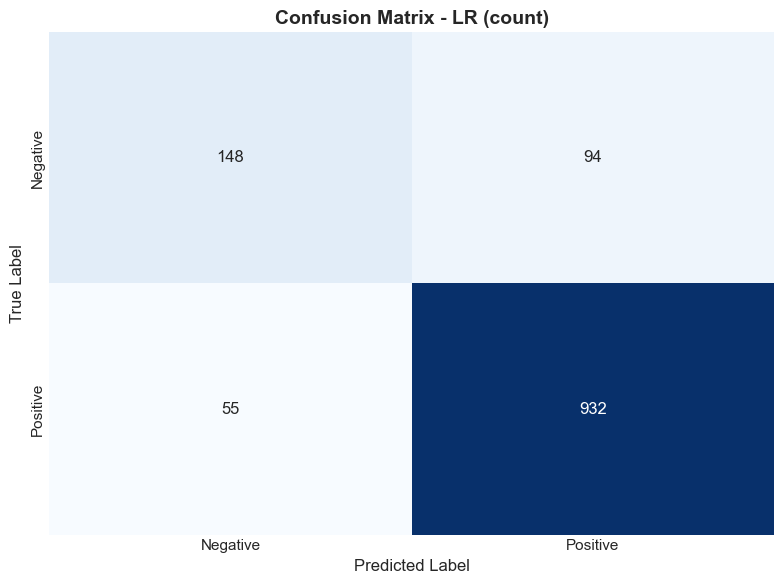


cross-validation (5-fold):
mean accuracy: 0.8692
std deviation: 0.0110
scores: [0.85636856 0.87924016 0.88195387 0.85617368 0.8724559 ]

training logistic regression with tfidf vectorizer

LR (tfidf) performance metrics:
accuracy:  0.8291
precision: 0.8278
recall:    0.9939
f1 score:  0.9033

classification report:
              precision    recall  f1-score   support

           0       0.86      0.16      0.27       242
           1       0.83      0.99      0.90       987

    accuracy                           0.83      1229
   macro avg       0.85      0.58      0.58      1229
weighted avg       0.83      0.83      0.78      1229



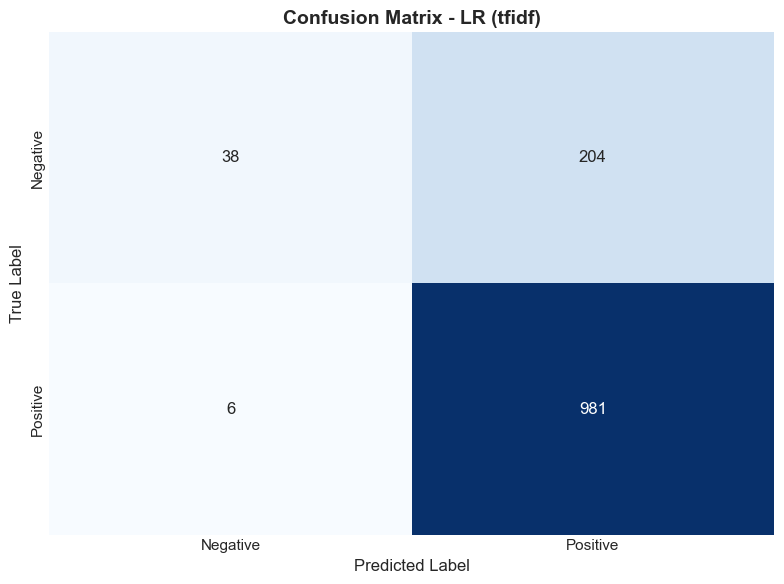


cross-validation (5-fold):
mean accuracy: 0.8253
std deviation: 0.0048
scores: [0.8197832  0.81953867 0.82632293 0.83039349 0.83039349]


In [3]:
# label and split
df['label'] = (df['polarity'] > 0).astype(int)
X = df['clean_text']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=1)

print(f"training data: {X_train.shape[0]} samples")
print(f"test data: {X_test.shape[0]} samples")
print(f"positive sentiment: {y.mean()*100:.2f}%")
print(f"negative sentiment: {(1-y.mean())*100:.2f}%")

# vectorizers setup
vecs = {
    'count': CountVectorizer(max_features=5000),
    'tfidf': TfidfVectorizer(max_features=5000)
}

# performance metrics
def evaluate_classifier(model, X_pred, y_true, model_name):
    y_pred = model.predict(X_pred)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    
    print(f"\n{model_name} performance metrics:")
    print(f"accuracy:  {acc:.4f}")
    print(f"precision: {prec:.4f}")
    print(f"recall:    {rec:.4f}")
    print(f"f1 score:  {f1:.4f}")
    
    print("\nclassification report:")
    print(classification_report(y_true, y_pred))
    
    # confusion matrix visualization
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - {model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.xticks([0.5, 1.5], ['Negative', 'Positive'], fontsize=11)
    plt.yticks([0.5, 1.5], ['Negative', 'Positive'], fontsize=11)
    plt.tight_layout()
    plt.savefig(f'confusion_matrix_{model_name.replace(" ", "_").lower()}.png', dpi=300)
    plt.show()
    
    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1
    }

# model evaluation results
results = {}

# logistic regression models
for name, vect in vecs.items():
    print(f"\n{'='*50}")
    print(f"training logistic regression with {name} vectorizer")
    X_tr = vect.fit_transform(X_train)
    X_te = vect.transform(X_test)
    
    lr = LogisticRegression(max_iter=1000, random_state=1)
    lr.fit(X_tr, y_train)
    
    model_name = f"LR ({name})"
    results[model_name] = evaluate_classifier(lr, X_te, y_test, model_name)
    
    # cross validation
    cv_scores = cross_val_score(lr, X_tr, y_train, cv=5, scoring='accuracy')
    print(f"\ncross-validation (5-fold):")
    print(f"mean accuracy: {cv_scores.mean():.4f}")
    print(f"std deviation: {cv_scores.std():.4f}")
    print(f"scores: {cv_scores}")



training random forest with count vectorizer

RF (count) performance metrics:
accuracy:  0.8299
precision: 0.8359
recall:    0.9807
f1 score:  0.9026

classification report:
              precision    recall  f1-score   support

           0       0.73      0.21      0.33       242
           1       0.84      0.98      0.90       987

    accuracy                           0.83      1229
   macro avg       0.78      0.60      0.62      1229
weighted avg       0.82      0.83      0.79      1229



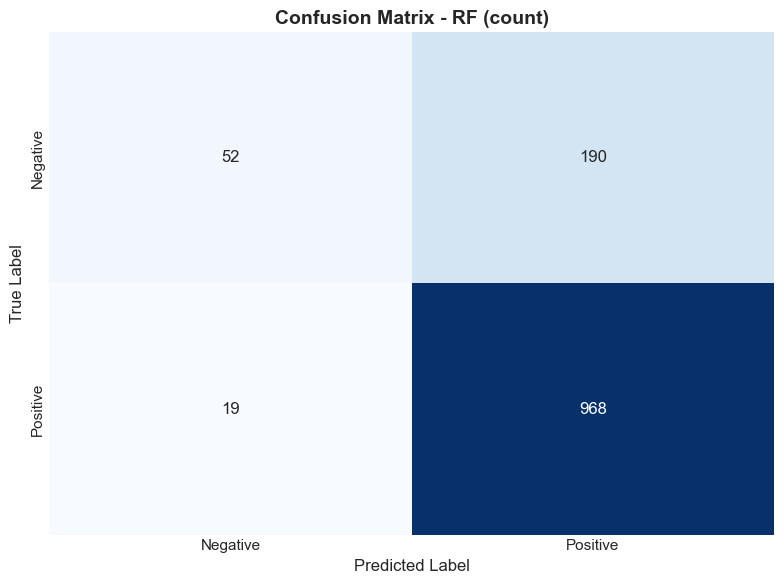


cross-validation (5-fold):
mean accuracy: 0.8375
std deviation: 0.0052
scores: [0.8401084  0.82903664 0.83989145 0.83446404 0.84396201]

training random forest with tfidf vectorizer

RF (tfidf) performance metrics:
accuracy:  0.8267
precision: 0.8258
recall:    0.9939
f1 score:  0.9021

classification report:
              precision    recall  f1-score   support

           0       0.85      0.14      0.25       242
           1       0.83      0.99      0.90       987

    accuracy                           0.83      1229
   macro avg       0.84      0.57      0.57      1229
weighted avg       0.83      0.83      0.77      1229



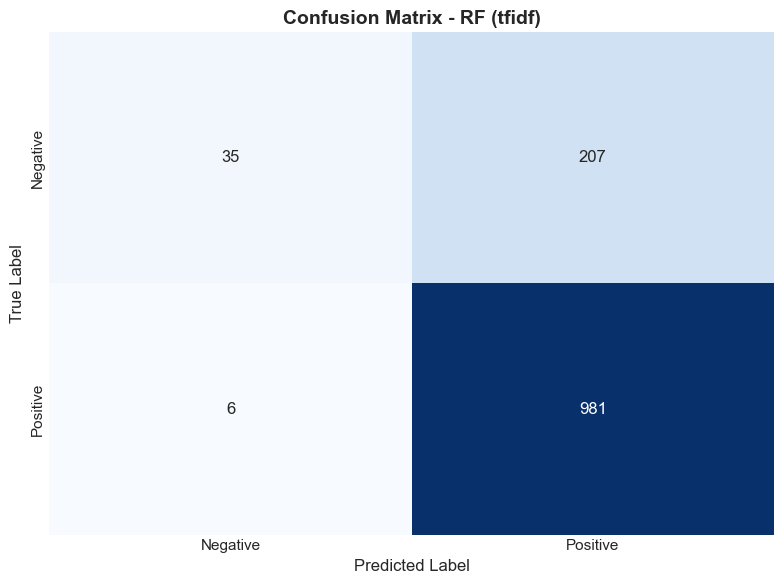


cross-validation (5-fold):
mean accuracy: 0.8226
std deviation: 0.0072
scores: [0.83333333 0.81275441 0.81818182 0.82767978 0.82089552]

hyperparameter tuning for random forest
Fitting 5 folds for each of 54 candidates, totalling 270 fits

best parameters:
max_depth: None
min_samples_leaf: 1
min_samples_split: 2
n_estimators: 100

best cross-validation score: 0.8375

evaluating tuned random forest model

RF Tuned performance metrics:
accuracy:  0.8299
precision: 0.8359
recall:    0.9807
f1 score:  0.9026

classification report:
              precision    recall  f1-score   support

           0       0.73      0.21      0.33       242
           1       0.84      0.98      0.90       987

    accuracy                           0.83      1229
   macro avg       0.78      0.60      0.62      1229
weighted avg       0.82      0.83      0.79      1229



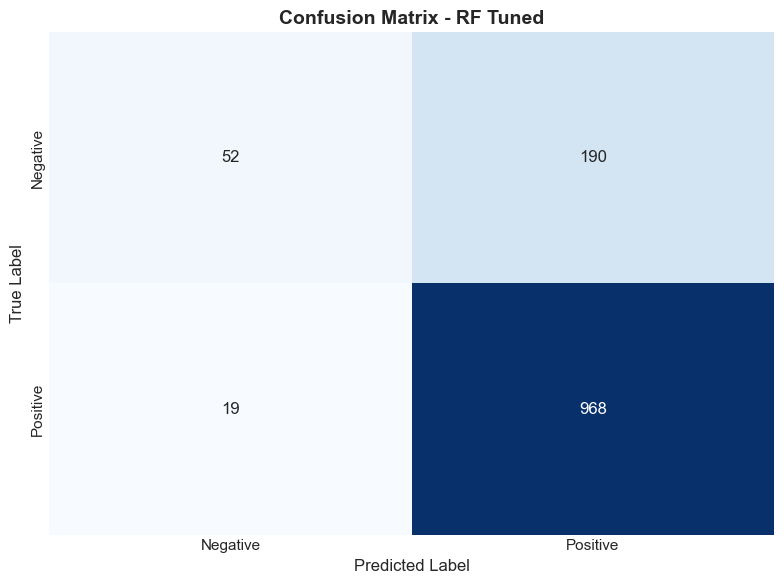

<Figure size 1200x800 with 0 Axes>

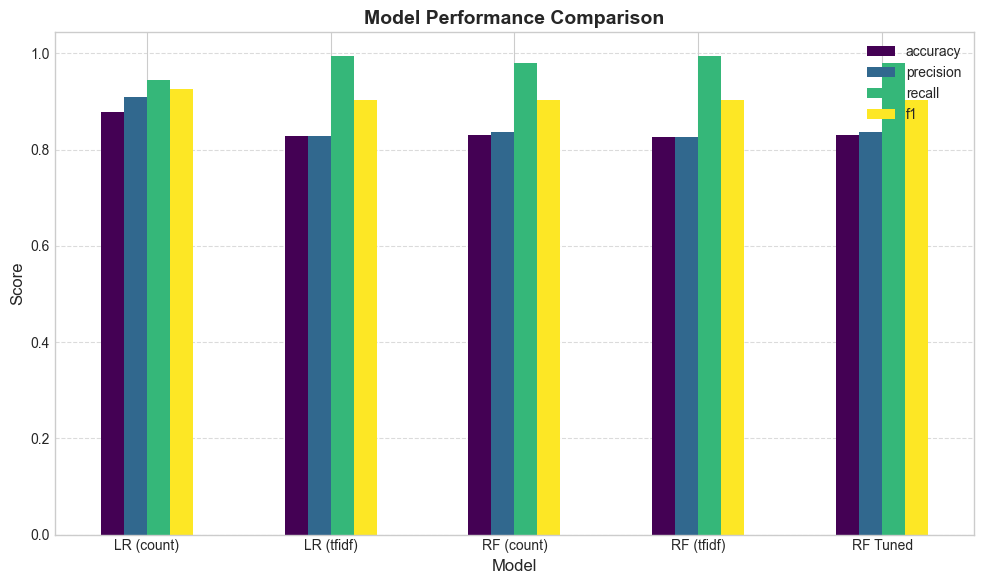

In [4]:
# random forest models
for name, vect in vecs.items():
    print(f"\n{'='*50}")
    print(f"training random forest with {name} vectorizer")
    X_tr = vect.fit_transform(X_train)
    X_te = vect.transform(X_test)
    
    rf = RandomForestClassifier(n_estimators=100, random_state=1)
    rf.fit(X_tr, y_train)
    
    model_name = f"RF ({name})"
    results[model_name] = evaluate_classifier(rf, X_te, y_test, model_name)
    
    # cross validation
    cv_scores = cross_val_score(rf, X_tr, y_train, cv=5, scoring='accuracy')
    print(f"\ncross-validation (5-fold):")
    print(f"mean accuracy: {cv_scores.mean():.4f}")
    print(f"std deviation: {cv_scores.std():.4f}")
    print(f"scores: {cv_scores}")

# hyperparameter tuning for random forest with count vectorizer
print(f"\n{'='*50}")
print("hyperparameter tuning for random forest")

count_vec = CountVectorizer(max_features=5000).fit(X_train)
X_tr = count_vec.transform(X_train)
X_te = count_vec.transform(X_test)

params = {
    'n_estimators': [100, 300], 
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

gs = GridSearchCV(
    RandomForestClassifier(random_state=1),
    params, 
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1
)

gs.fit(X_tr, y_train)
best_rf = gs.best_estimator_

print("\nbest parameters:")
for param, value in gs.best_params_.items():
    print(f"{param}: {value}")

print(f"\nbest cross-validation score: {gs.best_score_:.4f}")

# evaluate tuned model
print("\nevaluating tuned random forest model")
model_name = "RF Tuned"
results[model_name] = evaluate_classifier(best_rf, X_te, y_test, model_name)

# performance comparison
metrics = ['accuracy', 'precision', 'recall', 'f1']
model_names = list(results.keys())
comparison = {metric: [results[model][metric] for model in model_names] for metric in metrics}
comparison_df = pd.DataFrame(comparison, index=model_names)

plt.figure(figsize=(12, 8))
comparison_df.plot(kind='bar', rot=0, colormap='viridis')
plt.title('Model Performance Comparison', fontsize=14, fontweight='bold')
plt.xlabel('Model', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=300)
plt.show()


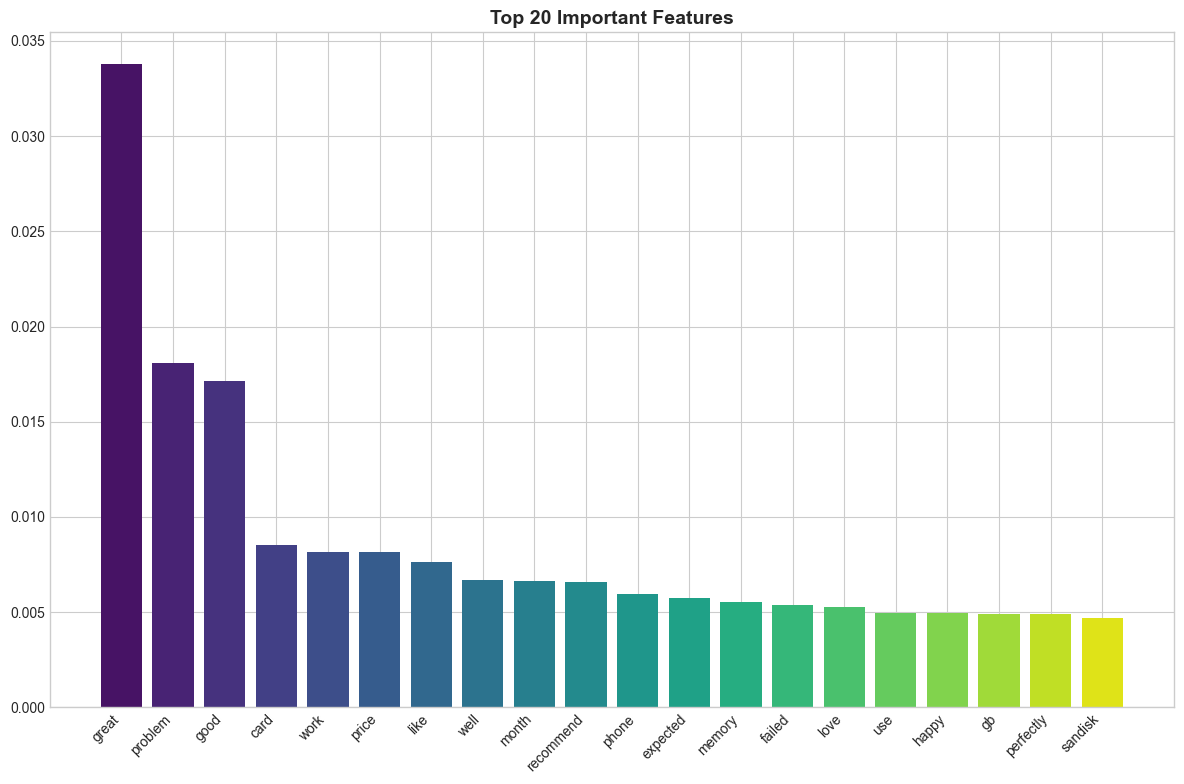


example predictions:
Text                                     | Prediction | Confidence
-----------------------------------------+------------+-----------
this product is very good :)             | positive   | 0.9900
this product is very bad :(              | negative   | 0.5500
amazing quality and excellent customer s | positive   | 0.8200
terrible experience, would not recommend | positive   | 0.7000


In [5]:
# feature importance visualization for random forest
if hasattr(best_rf, 'feature_importances_'):
    # get feature names
    feature_names = np.array(count_vec.get_feature_names_out())
    
    # get top 20 features
    importance = best_rf.feature_importances_
    indices = np.argsort(importance)[::-1][:20]
    
    plt.figure(figsize=(12, 8))
    plt.title('Top 20 Important Features', fontsize=14, fontweight='bold')
    plt.bar(range(20), importance[indices], align='center', color=sns.color_palette('viridis', 20))
    plt.xticks(range(20), feature_names[indices], rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.savefig('feature_importance.png', dpi=300)
    plt.show()

# example predictions function
def predict_sentiment(text, model, vectorizer):
    processed_text = preprocess(text)
    vectorized_text = vectorizer.transform([processed_text])
    prediction = model.predict(vectorized_text)[0]
    probability = model.predict_proba(vectorized_text)[0]
    
    result = 'positive' if prediction else 'negative'
    conf = probability[1] if prediction else probability[0]
    
    return result, conf

# example inferences
test_examples = [
    "this product is very good :)",
    "this product is very bad :(",
    "amazing quality and excellent customer service",
    "terrible experience, would not recommend"
]

print("\nexample predictions:")
print(f"{'='*50}")
print(f"{'Text':<40} | {'Prediction':<10} | {'Confidence':<10}")
print(f"{'-'*40}-+-{'-'*10}-+-{'-'*10}")

for example in test_examples:
    sentiment, confidence = predict_sentiment(example, best_rf, count_vec)
    print(f"{example[:40]:<40} | {sentiment:<10} | {confidence:.4f}")